In [35]:
import pandas as pd
from sqlalchemy import create_engine
import sys
sys.path.append('..')
from src.database_info import database, game_id
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)


engine = create_engine(database)


query = 'SELECT * FROM combos_for_battlefield WHERE higher_post_game_id = %s'
query_2 = '''SELECT lower_post_last_attack_landed, higher_post_last_attack_landed, higher_post_frame, higher_post_internal_character_id, higher_post_action_state_id, higher_post_percent,
lower_post_action_state_id, lower_post_percent, lower_post_internal_character_id, lower_post_l_cancel_status, higher_post_l_cancel_status FROM combos_for_battlefield'''
df = pd.read_sql(query, engine, params=(game_id,))
df_2 = pd.read_sql(query_2, engine, params=(game_id,))


action_state_id_to_check_getting_hit = [0, 1, 2, 4, 8, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 181, 227, 228, 238, 239, 240, 241, 242]
death_action_state_ids = [0, 1, 2, 4, 8]

last_frame = None
current_combo_id = 0
higher_port_post_percent = 0.0
lower_port_post_percent = 0.0

successful_l_cancel = 1
unsuccessful_l_cancel = 0
no_l_cancel_on_frame = None

df_2['combo_block_for_model'] = None
df_2['character_creating_combo_for_model'] = None
df_2['humanlabel'] = None
df_2['first_attack_state_to_hit_in_combo_for_model'] =  None
df_2['last_attack_state_to_hit_in_combo_for_model'] = None
df_2['lower_port_l_cancel_for_model'] = None
df_2['higher_port_l_cancel_for_model'] = None

for index, row in df_2.iterrows():
    current_frame = row['higher_post_frame'] 

    # Check for frame gaps to identify new combos
    if last_frame is not None and (current_frame - last_frame > 1):
        current_combo_id += 1

    # Label based on action_state_id
    if row["lower_post_action_state_id"] not in action_state_id_to_check_getting_hit:#lower port player creating combo
        df_2.at[index, 'combo_block_for_model'] = current_combo_id 
        df_2.at[index, 'character_creating_combo_for_model'] = 0
        df_2.at[index, 'humanlabel'] = 'fox'
    elif row["higher_post_action_state_id"] not in action_state_id_to_check_getting_hit: #higher port player creating combo
        df_2.at[index, 'combo_block_for_model'] = current_combo_id 
        df_2.at[index, 'character_creating_combo_for_model'] = 1
        df_2.at[index, 'humanlabel'] = 'falco'

    if row['lower_post_action_state_id'] in death_action_state_ids:
        lower_port_post_percent = 0.0
    
    if row['higher_post_action_state_id'] in death_action_state_ids:
        higher_port_post_percent = 0.0

    if row['lower_post_percent'] > lower_port_post_percent:
        df_2.at[index, 'first_attack_state_to_hit_in_combo_for_model'] = row['higher_post_last_attack_landed']
        lower_port_post_percent = row['lower_post_percent']

    if row['higher_post_percent'] > higher_port_post_percent:
        df_2.at[index, 'first_attack_state_to_hit_in_combo_for_model'] = row['lower_post_last_attack_landed']
        higher_port_post_percent = row['higher_post_percent']
    
    if row['lower_post_l_cancel_status'] == 0:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = no_l_cancel_on_frame
    
    elif row['lower_post_l_cancel_status'] == 1:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = successful_l_cancel
    
    elif row['lower_post_l_cancel_status'] == 2:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = unsuccessful_l_cancel

    if row['higher_post_l_cancel_status'] == 0:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = no_l_cancel_on_frame
    
    elif row['higher_post_l_cancel_status'] == 1:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = successful_l_cancel
    
    elif row['higher_post_l_cancel_status'] == 2:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = unsuccessful_l_cancel
    
    last_frame = current_frame

    #if the state of the frame before was not in the check to get hit frames and it is now in death action state
    #then we want to label this as dying not in hitstun, and we want to label the combo row as 

last_row = df_2.iloc[-1]

print(last_row)

mask_higher = df_2['higher_post_action_state_id'].isin(death_action_state_ids) & df_2['higher_post_action_state_id'].duplicated(keep='first')
mask_lower = df_2['lower_post_action_state_id'].isin(death_action_state_ids) & df_2['lower_post_action_state_id'].duplicated(keep='first')


combined_mask = mask_higher | mask_lower

df_2 = df_2.loc[~combined_mask]

df_2._append(last_row)

df_2.to_html('your_dataframe.html')


filtered_df = df_2[(df_2['higher_post_action_state_id'].isin(death_action_state_ids)) | (df_2['lower_post_action_state_id'].isin(death_action_state_ids))]

print(df_2.iloc[-1])




lower_post_last_attack_landed                          17
higher_post_last_attack_landed                         10
higher_post_frame                                    8277
higher_post_internal_character_id                      22
higher_post_action_state_id                           253
higher_post_percent                                  4.73
lower_post_action_state_id                              0
lower_post_percent                              84.979996
lower_post_internal_character_id                        1
lower_post_l_cancel_status                              0
higher_post_l_cancel_status                             0
combo_block_for_model                                  75
character_creating_combo_for_model                      1
humanlabel                                          falco
first_attack_state_to_hit_in_combo_for_model           10
last_attack_state_to_hit_in_combo_for_model          None
lower_port_l_cancel_for_model                        None
higher_port_l_

In [ ]:
pd.set_option('display.max_rows', 1000)
df['higher_post_action_state_id'].value_counts()

filtered_df = df[df['higher_post_action_state_id'] == 67]
print(filtered_df)



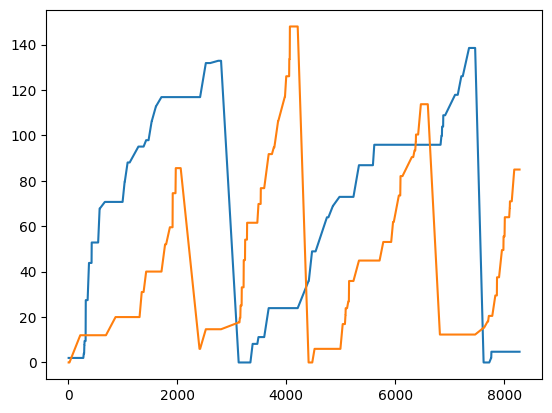

In [16]:
plt.plot(df['higher_post_frame'], df['higher_post_percent'])
plt.plot(df['lower_post_frame'], df['lower_post_percent'])
plt.show()
